In [46]:
import torch
import torchvision.transforms as T
from torch import nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from base64 import b64encode
from tqdm.notebook import tqdm
import numpy as np

def show_grid(maxn=20, w=3, h=3):
  """ Assuming images have been saved in steps/ and there are 
  at least maxn of them with the naming convention 0001.jpeg.
  This function loads w x h images and shows them in a grid.
  Useful for a quick preview to see if anything interesting is 
  happening"""
  fig, axs = plt.subplots(h, w)
  plt.tight_layout()
  for x in range(h):
    for y in range(w):
      i = int(maxn * (x*w+y)/(w*h))
      axs[x][y].imshow(Image.open(f'steps/{i:05}.jpeg'))

def render(ca, n=100, w=256, h=256, save_every=1, exp_frac=0, display_grid=True):
  """ Render n steps of a ca starting from a random grid.
  Saves an image every save_every steps into the steps/ folder.
  Smooths the aniation with exponential averaging set by exp_frac
  """
  grid = torch.rand(1, 1, w, h) # bs, channels, w, h
  im_array = np.array(grid[0][0].clip(0, 1))
  for i in tqdm(range(n)):
    grid = ca(grid)
    im_array = exp_frac*im_array + (1-exp_frac)*np.array(grid[0][0].clip(0, 1))
    im = Image.fromarray(np.uint8(cm.gist_earth(im_array)*255)).convert('RGB')
    if i % save_every == 0:
      im.save(f'steps/{i//save_every:05}.jpeg')
  if display_grid:
    show_grid(maxn=30, w=3, h=2)
    
def progress_video():
  # Turn the images in steps/ into a video with ffmpeg

  # Display it inline
  mp4 = open('video.mp4','rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  
  """ % data_url)

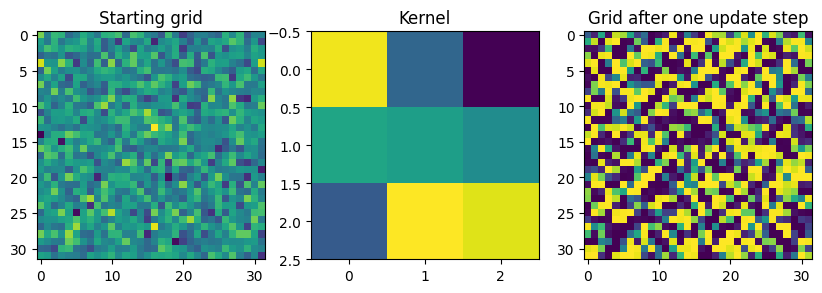

In [47]:
# Create our grid (32x32 for this demo)
grid = torch.randn(1, 1, 32, 32) # batch_size, channels, w, h

# Create a random kernel
kernel = torch.randn(1, 1, 3, 3) # batch_size, channels, kernel_size, kernel_size

# Define an activation function
act = torch.tanh

# Compute the output after one step:
output = act(F.conv2d(grid, kernel, padding='same')) # Think: What happens to the sizes if we remove padding?

# Visualize the various arrays:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(grid[0][0])
axs[0].set_title('Starting grid')
axs[1].imshow(kernel[0][0])
axs[1].set_title('Kernel')
axs[2].imshow(output[0][0])
axs[2].set_title('Grid after one update step')
plt.show()

In [48]:
class ConvCA(nn.Module):
  """Applies a convolutional kernel over an image and passes the result through
  an activation function."""
  def __init__(self, kernel_size=3, kernel_scale=0.5, act=torch.tanh):
    """Sets up the kernel and activation function.
     Defaults to:
    - kernel_size=3, 
    - kernel_scale=0.5, # sometimes it's nice to scale down the kernel
    - act=torch.tanh
    """
    super().__init__()
    self.kernel = torch.randn(1, 1, kernel_size, kernel_size)*kernel_scale
    self.act = act
    
  def forward(self, x):
    """Applies the kernel and activation function to a grid, x"""
    return self.act(F.conv2d(x, self.kernel, padding=1))

In [49]:
# Creating a ConvCA
ca = ConvCA()

# Applying the ca to the grid from before is now as easy as:
output = ca(grid)

print(grid.shape, output.shape) # Shape is maintained thanks to the padding.

torch.Size([1, 1, 32, 32]) torch.Size([1, 1, 32, 32])


  0%|          | 0/100 [00:00<?, ?it/s]

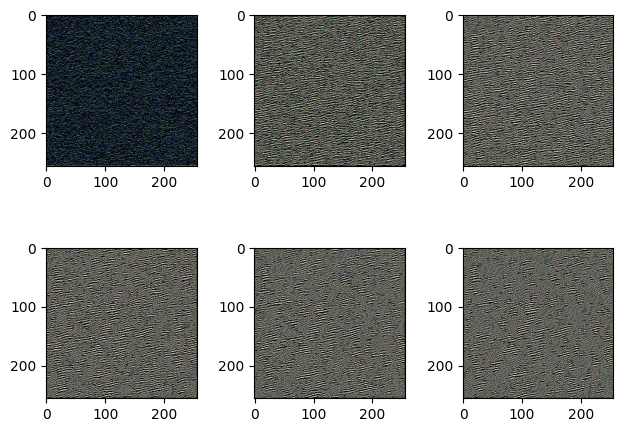

In [50]:
ca = ConvCA(kernel_scale=0.5)
render(ca)

In [51]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [52]:
class SimpleCA(nn.Module):
  def __init__(self, hidden_n=6, zero_w2=True, device=device):
    super().__init__()
    # The hard-coded filters:
    self.filters = torch.stack([torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
          torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
          torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
          torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])]).to(device)
    self.chn = 4

    # Our little 'brain'. 
    # Discuss: how is convolution with a 1x1 filter basically 
    # the same as defining an MLP with linear layers?
    self.w1 = nn.Conv2d(4*4, hidden_n, 1).to(device)
    self.relu = nn.ReLU()
    self.w2 = nn.Conv2d(hidden_n, 4, 1, bias=False).to(device)

    # It's useful to be able to start with small or 0 weights in 
    # the second layer, but you can experiment with skipping this
    # by setting zero_w2=False.
    if zero_w2:
      self.w2.weight.data.zero_()
    
    # Keep track of which device we're using
    self.device = device

  def perchannel_conv(self, x, filters):
    '''filters: [filter_n, h, w]'''
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
    y = torch.nn.functional.conv2d(y, filters[:,None])
    return y.reshape(b, -1, h, w)
    
  def forward(self, x, update_rate=0.5):
    y = self.perchannel_conv(x, self.filters) # Apply the filters
    y = self.w2(self.relu(self.w1(y))) # pass the result through out 'brain'
    b, c, h, w = y.shape

    # The update mask means that only some pixels are updated:
    update_mask = (torch.rand(b, 1, h, w).to(self.device)+update_rate).floor()

    # Note that the model output (y) is added to x where update_mask is 1:
    return x+y*update_mask
  
  def to_rgb(self, x):
    # TODO: rename this to_rgb & explain
    return x[...,:3,:,:]+0.5

  def make_video(self, x, n_steps=100):
    for i in range(n_steps):
      with torch.no_grad():
        x = ca(x)
        img = ca.to_rgb(x).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
        img = Image.fromarray(np.array(img*255).astype(np.uint8))
        img.save(f'steps/{i:05}.jpeg')
    return progress_video()

  def seed(self, n, sz=128):
    """Initializes n 'grids', size sz. In this case all 0s."""
    return torch.zeros(n, self.chn, sz, sz).to(self.device)

  def print_weights(self):
    """A mystery tool that will be useful later ;) """
    ws, bias = [p for p in self.w1.parameters()]
    nh = ws.shape[0]
    print(f'const int nh = {nh};')
    print(f'float b1[{len(bias)}] = float[{len(bias)}]({",".join([str(float(s)) for s in list(bias)])[:-1]});')
    nh = ws.shape[0]
    s = f'float w1[{nh*16}] = float[{nh*16}]('
    for p in ws.squeeze().flatten():
      p = str(float(p))
      s += p
      if not '.' in p:
        s += '.'
      s += ','
    s = s[:-1]+');'
    print(s)
    ws= [p for p in self.w2.parameters()][0]
    s = f'float w2[{nh*4}] = float[{nh*4}]('
    for p in ws.squeeze().flatten(): 
      p = str(float(p))
      s += p
      if not '.' in p:
        s += '.'
      s += ','
    s = s[:-1]+');'
    print(s)

In [53]:
ca = SimpleCA(hidden_n=8,zero_w2=False)
[p.shape for p in ca.parameters()]

[torch.Size([8, 16, 1, 1]), torch.Size([8]), torch.Size([4, 8, 1, 1])]

In [54]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True).to(device).features

def calc_styles(imgs):
  style_layers = [1, 6, 11, 18, 25]  
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None].to(device)
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None].to(device)
  x = (imgs-mean) / std
  grams = []
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      h, w = x.shape[-2:]
      y = x.clone()  # workaround for pytorch in-place modification bug(?)
      gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
      grams.append(gram)
  return grams

def calc_style_loss(grams_x, grams_y):
  loss = 0.0
  for x, y in zip(grams_x, grams_y):
    loss = loss + (x-y).square().mean()
  return loss

def to_nchw(img):
  img = torch.as_tensor(img).to(device)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

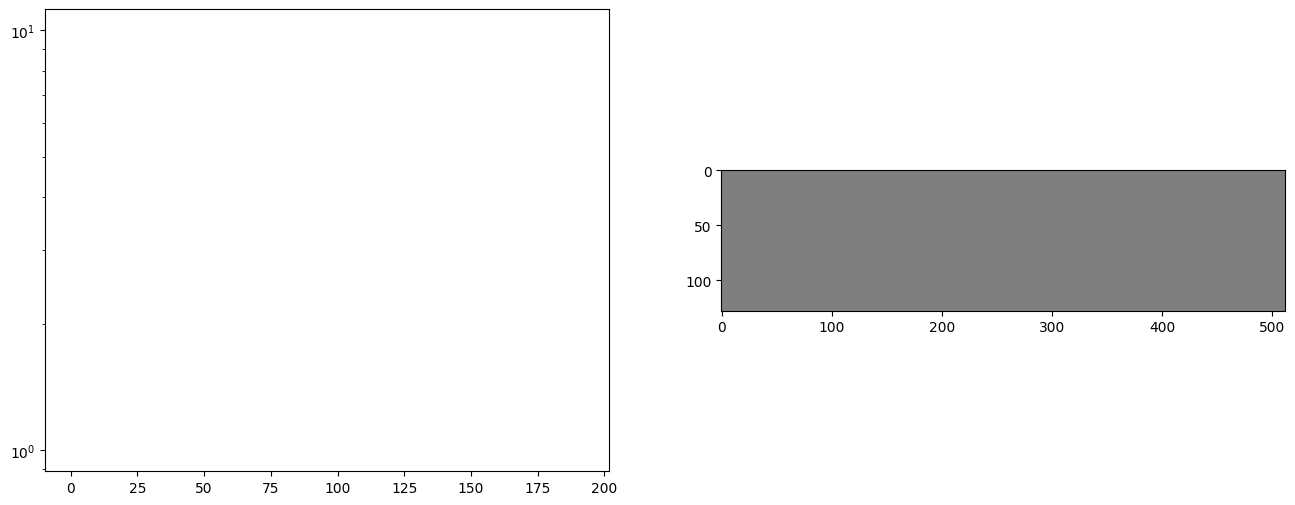

c:\Users\niedz\AppData\Local\anaconda3\envs\nn\Lib\site-packages\torch\utils\checkpoint.py:551: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\niedz\AppData\Local\anaconda3\envs\nn\Lib\site-packages\torch\utils\checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


step_n: 60  loss: 0.0  lr: 0.001

C:\Users\niedz\AppData\Local\Temp\ipykernel_1716\3709570715.py:56: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale('log')
C:\Users\niedz\AppData\Local\Temp\ipykernel_1716\3709570715.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(np.min(loss_log), loss_log[0])


step_n: 215  loss: 0.0  lr: 0.001

KeyboardInterrupt: 

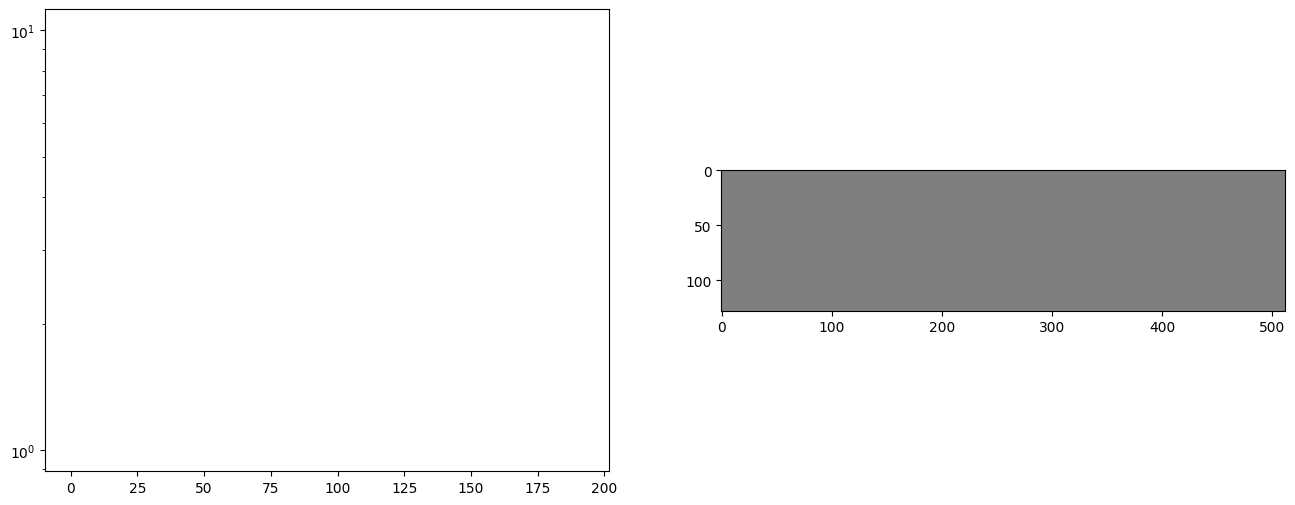

In [56]:
n_iter = 2000
hidden_n=16 #@param
ca = SimpleCA(hidden_n=hidden_n)
opt = torch.optim.Adam(ca.parameters(), 1e-3)

# If you want to schedule some drops in LR:
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.3)

loss_log = []

# Set up a 'pool' of grids
with torch.no_grad():
  pool = ca.seed(256)

# Live output
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
figure_display = display(fig,display_id=True)

#training loop 
for i in range(n_iter):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:
      x[:1] = ca.seed(1)
  step_n = np.random.randint(32, 96)
  # The following line is equivalent to this code:
  #   for k in range(step_n):
  #     x = ca(x)
  # It uses gradient checkpointing to save memory, which enables larger
  # batches and longer CA step sequences. Surprisingly, this version
  # is also ~2x faster than a simple loop, even though it performs
  # the forward pass twice!
  x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)
  imgs = ca.to_rgb(x)
  styles = calc_styles(imgs)
  overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  loss = overflow_loss
  
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%64==0:
      if i<1:
        pass
      else:
        axs[0].clear()
        axs[0].plot(loss_log, '.', alpha=0.3)
        axs[0].set_yscale('log')
        axs[0].set_ylim(np.min(loss_log), loss_log[0])
      output_ims = imgs.clip(0, 1).permute([0, 2, 3, 1]).cpu()
      axs[1].imshow(np.hstack(output_ims))
      figure_display.update(fig)
    if i%5 == 0:
      print('\rstep_n:', i,
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_last_lr()[0], end='')

clear_output()